# Описание

В этом ноутбуке будет рассмотрен процесс извлечения данных о треках, исполнителях, альбомах и т.д. из музыкального сервиса Spotify посредством программного интерфейса. Из полученных данных будет построен датасет, пригодный для дальнейшего изучения, будет проведен исследовательский анализ данных и построена регрессионная модель для предсказания популярности трека.

Ссылка на собранный датасет: https://www.kaggle.com/maxkuz/spotify-electronic-music-dataset

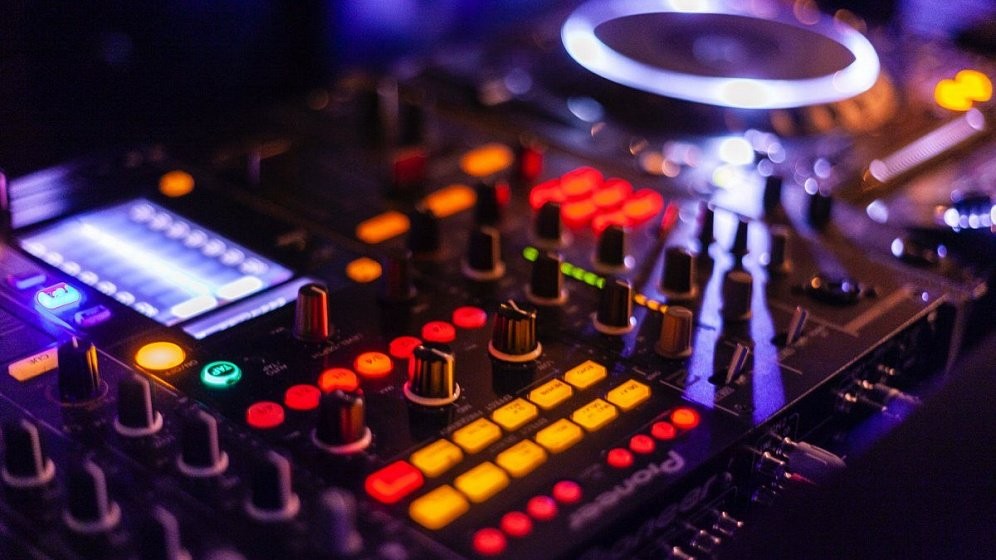

# Импорт библиотек и подключение к API Spotify

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import requests
from bs4 import BeautifulSoup
import datetime
import base64
import sys
import json
import spotipy
import spotipy.util as util
import spotipy.oauth2 as oauth2
from urllib.parse import urlencode
from collections import ChainMap
import re
import time
import concurrent.futures
import warnings
import datetime as dt
from sklearn.cluster import KMeans
import cv2
import os

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
plt.rcParams["figure.figsize"] = (10,6)

In [2]:
# Запускаем файл с данными для аутентификации

%run secrets.py

credentials = oauth2.SpotifyClientCredentials(
        client_id=client_id,
        client_secret=client_secret)

# token = credentials.get_access_token()
spotify = spotipy.Spotify(auth_manager=credentials)

Подключение произошло успешно. Можно приступать к работе!

# Формирование датасета

## Получение данных из DJ Mag Top 100

Нужно получить данные об исполнителях из известного рейтинга dj mag top 100, в котором содержатся наиболее известные диджеи и продюсеры в сфере электронной музыки. Необходимо собрать датасет, и для этого придется заняться парсингом сайтов. Далее нужно будет собрать данные о треках исполнителей.

In [3]:
import concurrent.futures

In [4]:
path = r'C:\Users\Максим\Desktop\Аналитика данных\Notebooks\Spotify_data'

In [5]:
# Составление датафрейма о положении диджеев в рейтинге dj mag top 100


def get_djs_rating_data(year):
    djs = []
    positions = []
    dj_years = []
    movements = []

    url = f'https://djmag.com/top100djs/?year={year}'
    r = requests.get(url)
    soup = BeautifulSoup(r.text, 'lxml')

    name_links = soup.find_all('div', class_='top100dj-name')
    pos_links = soup.find_all(
        'div', class_='views-field views-field-field-top100-position')
    pos_movements = soup.find_all('div', class_='top100dj-movement')

    for l in name_links:  # Имена диджеев
        djs.append(l.text.strip())

    for l in pos_links:  # Позиции в рейтинге
        positions.append(int(l.text.strip()))

    for i in pos_movements:  # Изменение позиций
        movements.append(i.text.strip())

    for i in range(len(pos_movements)):  # Год
        dj_years.append(year)

    djs_df = pd.DataFrame({
        'name': djs,
        'position': positions,
        'position_movement': movements,
        'year': dj_years
    })

    return djs_df

In [6]:
years = np.arange(2004, dt.datetime.now().year)

In [7]:
# %%time
# with concurrent.futures.ThreadPoolExecutor() as executor:
#     futures = [executor.submit(get_djs_rating_data, year) for year in years]
#     results = [result.result() for result in futures]
# djs_df = pd.concat(results)

In [8]:
# djs_df.to_csv(path+'\Djs_rating_data.csv', index=False)

In [9]:
# Читаем данные о диджеях из записанного в предыдущей ячейке csv файла

djs_df = pd.read_csv(path+'\Djs_rating_data.csv')

In [10]:
djs_df.head()

,name,position,position_movement,year
0,Tiësto,1,Re-entry,2004
1,Paul van Dyk,2,Re-entry,2004
2,Armin Van Buuren,3,Re-entry,2004
3,Sasha,4,Re-entry,2004
4,Ferry Corsten,5,Up 1,2004


In [11]:
# Все исполнители, которые хотя бы раз попадали в рейтинг
unique_djs = list(djs_df['name'].unique())
len(unique_djs)

413

## Получение дополнительных данных об исполнителях

In [12]:
def get_more_djs_data(dj):
    djs = []
    born_in = []
    url = f'https://www.last.fm/music/{dj}'
    r = requests.get(url)
    soup = BeautifulSoup(r.text, 'html.parser')
    data = soup.find_all('dd', {'class': 'catalogue-metadata-description'})
    result = [i.text for i in data]
    djs.append(dj)

    if len(result) == 2:  # Если даны все данные, берем вторую строку
        born_in.append(result[1])

    elif len(result) == 1:  # Если чего-то одного не хватает (даты или места)
        if len(
                re.findall('\d', str(result))
        ) > 0:  # Если это дата рождения (или продолжительность творческой деятельности)

            url = f'https://www.discogs.com/artist/{dj}'
            r = requests.get(url)
            soup = BeautifulSoup(r.text, 'html.parser')
            data = soup.find('div', {'class': 'readmore', 'id': 'profile'})

            if data is None:
                born_in.append(np.nan)
            else:
                data = data.text.strip()
                born_in.append(data)

        else:
            born_in.append(result[0])
    else:  # Если на last.fm не нашлось данных, поиск продолжится на сайте www.discogs.com
        url = f'https://www.discogs.com/artist/{dj}'
        r = requests.get(url)
        soup = BeautifulSoup(r.text, 'html.parser')
        data = soup.find('div', {'class': 'readmore', 'id': 'profile'})

        if data is None:
            born_in.append(np.nan)
        else:
            data = data.text.strip()
            born_in.append(data)

    djs_df_1 = pd.DataFrame({'name': djs, 'born_or_founded_in': born_in})
    time.sleep(0.5)

    return djs_df_1

In [13]:
# %%time
# with concurrent.futures.ThreadPoolExecutor() as executor:
#     futures = [executor.submit(get_more_djs_data, dj) for dj in unique_djs]
#     results = [result.result() for result in futures]
# djs_df_1 = pd.concat(results).reset_index(drop=True).dropna(subset=['name'])

In [14]:
# djs_df_1.to_csv(path + '\Djs_birth_place_data.csv', index=False)

In [15]:
djs_df_1 = pd.read_csv(path + '\Djs_birth_place_data.csv')

In [16]:
djs_df_1.isna().sum()

name                   0
born_or_founded_in    32
dtype: int64

In [17]:
# Один из диджеев не нашелся вовсе, поэтому лучше перезаписать переменную unique_djs, чтобы далее не было пропусков

unique_djs = list(djs_df_1['name'])

In [18]:
# Исполнители, страну рождения которых не удалось найти на last.fm

unfound_place_djs = list(djs_df_1[djs_df_1.isna().any(axis=1)]['name'])

In [19]:
djs_df_1.shape

(412, 2)

In [20]:
# pd.set_option('display.max_colwidth', None)

In [21]:
djs_df_1.head()

,name,born_or_founded_in
0,Tiësto,"Breda, Breda, Noord-Brabant, Netherlands"
1,Paul van Dyk,"Eisenhüttenstadt, Brandenburg, Germany"
2,Armin Van Buuren,"Leiden, Zuid-Holland, Netherlands"
3,Sasha,British DJ and producer. \r Born: 4 September ...
4,Ferry Corsten,"Rotterdam, Rotterdam, Zuid-Holland, Netherlands"


## Получение треков

In [22]:
# Получить id диджеев на спотифай
def get_ids(dj):
    dj = dj.upper()
    search = spotify.search(dj, type='artist').get('artists').get('items')
    if len(search)>0:
        names = dict(ChainMap(*search)).get('name').upper()
        id = dict(ChainMap(*search)).get('id')
        if dj==names:
            return id

In [23]:
# djs_ids = [get_ids(i) for i in unique_djs]
# djs_ids = [i for i in djs_ids if i]

In [24]:
# with open(path + "\Djs_ids.txt", "w") as f:
#     f.write("\n".join(djs_ids))

In [25]:
with open(path + '\Djs_ids.txt') as f:
    djs_ids = f.readlines()
    djs_ids = [x.strip() for x in djs_ids] 

In [26]:
len(djs_ids)

364

In [27]:
def artist_tracks():
    for artist_id in djs_ids:
        albums_data = spotify.artist_albums(artist_id, limit=50)
        albums = [albums_data.get('items')[i].get('id') for i in range(len(albums_data.get('items')))]
        album_tracks = []
        artist_ids = []
        for n in range(len(albums)):
            album_tracks_data = spotify.album_tracks(albums[n]).get('items')
            for i in range(len(album_tracks_data)):
                d = {}
                if artist_id in [d.get('id') for d in album_tracks_data[i].get('artists')] and album_tracks_data[i].get('duration_ms')>120000:
                    d['track_id'] = album_tracks_data[i].get('id')
                    d['artist_id'] = artist_id
                    file = path + '\Ids.json'
                    with open(file, 'a') as f:
                        f.write(json.dumps(d) + '\n')

In [28]:
# %%time
# artist_tracks()

In [29]:
def flatten(l):
    return [item for sublist in l for item in sublist]

In [30]:
ids_df = pd.read_json(path + '\Ids.json', lines=True)

In [31]:
# albums_ids = []
# for chunk in range(len(tracks_chunks)):
#     track_list = tracks_chunks[chunk]
#     tracks_search = spotify.tracks(track_list).get('tracks')
#     for i in tracks_search:
#         albums_ids.append(i.get('album').get('id'))

In [32]:
# ids_df = pd.DataFrame({'track_id':tracks_ids, 'artist_id':artists_ids, 'album_id':albums_ids})

In [33]:
# ids_df.to_json(path_or_buf=path+'\Ids.json', orient='records', lines=True)

In [34]:
tracks_ids = list(ids_df['track_id'])
artists_ids = list(ids_df['artist_id'])
albums_ids = list(ids_df['album_id'])

In [35]:
ids_df.shape

(60485, 3)

## Получение информации о треках

In [36]:
# Получение информации об исполнителях из Spotify
def spotify_djs_data():
    for chunk in range(len(djs_chunks)):
        artist_keys = ['followers', 'genres', 'id', 'name', 'popularity']
        artists_data = spotify.artists(djs_chunks[chunk])
        for i in range(len(artists_data.get('artists'))):
            d = {}
            for k in artist_keys:
                if k != 'followers':
                    d[k] = artists_data.get('artists')[i].get(k)
                else:
                    d[k] = artists_data.get('artists')[i].get(k).get('total')

            file = path + '\Artists_spotify_data.json'
            with open(file, 'a') as f:
                f.write(json.dumps(d) + '\n')

In [37]:
# %%time
# spotify_djs_data()

In [38]:
main_djs_df = pd.read_json(path + '\Artists_spotify_data.json', lines=True)

In [39]:
main_djs_df.head()

,followers,genres,id,name,popularity
0,64108,[psychedelic trance],40EsdChhIP1ZT9RYOcfUI0,Astral Projection,36
1,16010,"[progressive house, trance]",03kG9mdI2xdVCLOsFt26GR,Marcel Woods,34
2,58519,"[bubble trance, dutch trance, progressive hous...",1eQe86RbDKRIiGZk08r9YJ,Rank 1,51
3,37071,"[progressive house, progressive trance, trance...",1dbzT291PCwwYJK0l3Tr1n,Christina Novelli,57
4,17498,"[circuit, disco house, electro house, funky te...",2LTa2TleomBhi05k8khxCF,Antoine Clamaran,41


In [40]:
main_djs_df.shape

(363, 5)

In [41]:
# Разбиваем идентификаторы на блоки
def chunks(lst, n):
    for i in range(0, len(lst), n):
        yield lst[i:i + n]
        
djs_chunks = list(chunks(list(set(artists_ids)), 50))
tracks_chunks = list(chunks(tracks_ids, 50))

unique_albums_ids = list(set(albums_ids))
albums_chunks = list(chunks(unique_albums_ids, 20))
artists_chunks = list(chunks(artists_ids, 50))

In [42]:
def tracks_data_scraper():    
    for chunk in range(len(tracks_chunks)):
#     for chunk in [0, 1]:
        try:
            tracks_data_values = []
            tracks_list = tracks_chunks[chunk]
            tracks_search = spotify.tracks(tracks_list).get('tracks')

            # Общие данные о треках
            tracks_data_keys = [
                'name', 'id', 'popularity', 'track_number', 'explicit',
                'available_markets', 'artists', 'album'
            ]

            for item, id_ in zip(tracks_search, artists_chunks[chunk]):
                for key in tracks_data_keys:
                    if key != 'artists' and key != 'album':
                        tracks_data = item.get(key)
                        tracks_data_values.append(tracks_data)
                    elif key == 'artists':
                        for k in ['name', 'id']:
                            tracks_data = list(j.get(k) for j in item.get('artists'))
                            tracks_data_values.append(tracks_data)
                    elif key == 'album':
                        tracks_data = item.get('album').get('id')
                        tracks_data_values.append(tracks_data)
                tracks_data_values.append(id_)

            tracks_data_keys = [
                'track_name', 'track_id', 'track_popularity', 'track_number', 'explicit',
                'available_markets', 'artists_names', 'artists_ids', 'album_id', 'main_artist_id'
            ]                
            tracks_data_lists = list(chunks(tracks_data_values, len(tracks_data_keys)))
            tracks_dicts = []

            for i in range(len(tracks_data_lists)):
                d = {}
                for data, key in zip(tracks_data_keys, tracks_data_lists[i]):
                    di = {data:key}
                    d.update(di)
                tracks_dicts.append(d)

            file = path + '\Tracks_data.json'
            for i in range(len(tracks_list)):
                with open(file, 'a') as f:
                    f.write(json.dumps(tracks_dicts[i])+'\n')      

            #Музыкальные данные
            audio_features = spotify.audio_features(tracks_list)
            audio_features_keys = [
                'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
                'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
                'duration_ms', 'time_signature'
            ]
            audio_features_values = []
            for item, id_ in zip(audio_features, tracks_chunks[chunk]):
                for key in audio_features_keys:
                    audio_features_values.append(item.get(key))
                audio_features_values.append(id_)

            audio_features_dicts = []
            audio_features_keys = [
                'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
                'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
                'duration_ms', 'time_signature', 'track_id'
            ]

            audio_features_lists = list(chunks(audio_features_values, len(audio_features_keys)))

            for i in range(len(audio_features_lists)):
                d = {}
                for data, key in zip(audio_features_keys, audio_features_lists[i]):
                    di = {data:key}
                    d.update(di)
                audio_features_dicts.append(d)

                file = path + '\Audio_data.json'
            for i in range(len(tracks_list)):
                with open(file, 'a') as f:
                    f.write(json.dumps(audio_features_dicts[i])+'\n')
        except:
            continue

In [43]:
# %%time
# tracks_data_scraper()

In [44]:
def albums_data_scraper():    
    for chunk in range(len(albums_chunks)):
        try:
            albums_data = []
            albums_list = albums_chunks[chunk]
            albums_search = spotify.albums(albums_list).get('albums')
            albums_data_values = []
            albums_keys = ['name', 'id', 'release_date', 'total_tracks', 'type', 'images', 'popularity', 'label']

            for item in albums_search:
                for key in albums_keys:
                    if key != 'images':
                        albums_data = item.get(key)
                        albums_data_values.append(albums_data)
                    else:
                        albums_data = item.get(key)[1].get('url')
                        albums_data_values.append(albums_data)

            albums_data_lists = list(chunks(albums_data_values, len(albums_keys)))
            albums_dicts = []
            albums_keys = ['album_name', 'album_id', 'album_release_date', 'total_tracks', 'type', 'image_url', 'album_popularity', 'album_label']

            for i in range(len(albums_data_lists)):
                d = {}
                for data, key in zip(albums_keys, albums_data_lists[i]):
                    di = {data:key}
                    d.update(di)
                albums_dicts.append(d)

            file = path + '\Albums_data.json'
            for i in range(len(albums_list)):
                with open(file, 'a') as f:
                    f.write(json.dumps(albums_dicts[i])+'\n')
        except:
            continue

In [45]:
# %%time
# albums_data_scraper()

## Составление датасета и предобработка

### Чтение файлов

In [46]:
tracks_df = pd.read_json(path + '\Tracks_data.json', lines=True)
tracks_df.drop_duplicates(subset='track_id', inplace=True)

audio_features_df = pd.read_json(path + '\Audio_data.json', lines=True)
audio_features_df.drop_duplicates(subset='track_id', inplace=True)

albums_df = pd.read_json(path + '\Albums_data.json', lines=True)
albums_df.drop_duplicates(subset='album_id', inplace=True)

artists_df = pd.read_json(path + '\Artists_spotify_data.json', lines=True)
artists_df.drop_duplicates(subset='id', inplace=True)

print(tracks_df.shape[0])
print(audio_features_df.shape[0])
print(albums_df.shape[0])
print(artists_df.shape[0])

59651
59176
16839
363


In [47]:
tracks_df.head(2)

,track_name,track_id,track_popularity,track_number,explicit,available_markets,artists_names,artists_ids,album_id,main_artist_id
0,God Is A Dancer,6mIrY9axk9DkBCk4eHXL6c,41,1,False,"[AD, AE, AG, AL, AR, AT, AU, BA, BB, BE, BG, B...","[Tiësto, Mabel]","[2o5jDhtHVPhrJdv3cEQ99Z, 1MIVXf74SZHmTIp4V4paH4]",6CIslPQSknp875cigkhKJC,2o5jDhtHVPhrJdv3cEQ99Z
1,Nothing Really Matters,39TATbzOKDwiWdrmuQBLGK,40,2,False,"[AD, AE, AG, AL, AR, AT, AU, BA, BB, BE, BG, B...","[Tiësto, Becky Hill]","[2o5jDhtHVPhrJdv3cEQ99Z, 4EPJlUEBy49EX1wuFOvtjK]",6CIslPQSknp875cigkhKJC,2o5jDhtHVPhrJdv3cEQ99Z


In [48]:
audio_features_df.head(2)

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,track_id
0,0.773,0.747,1,-3.908,0,0.0820,0.02410,0.000006,0.342,0.833,119.962,168125,4,6mIrY9axk9DkBCk4eHXL6c
1,0.732,0.847,5,-4.255,0,0.0426,0.00491,0.000002,0.281,0.697,123.023,157478,4,39TATbzOKDwiWdrmuQBLGK


In [49]:
albums_df.head(2)

,album_name,album_id,album_release_date,total_tracks,type,image_url,album_popularity,album_label
0,Substance (Mixed),6KofNGAeH4yml2sflCvRwK,2002-04-22,12,album,https://i.scdn.co/image/ab67616d00001e02f5c222...,11,Soundcolours
1,Sweet Taste,7fnwg5uigGkDextI8up4YQ,2020-12-03,1,album,https://i.scdn.co/image/ab67616d00001e02553d2e...,0,Teta Records


In [50]:
df = pd.merge(tracks_df, audio_features_df)
df = df.merge(albums_df)
df = df.merge(artists_df, left_on='main_artist_id', right_on='id', how='outer')

In [51]:
df.shape

(59176, 35)

### Обработка данных и добавление признаков

In [52]:
df = df.rename(columns={'name':'artist_name', 'popularity':'artist_popularity'})
df = df.drop(columns=['id'])
df['artist_name'] = df['artist_name'].apply(lambda x: x.upper())

In [53]:
djs_df['name'] = djs_df['name'].apply(lambda x: str(x).upper())

djs_df_1['name'] = djs_df_1['name'].apply(lambda x: x.upper())

In [54]:
position_list = djs_df.groupby('name')['position'].apply(list)
year_list = djs_df.groupby('name')['year'].apply(list)
pos_year_df = pd.merge(year_list, position_list, on='name')

In [55]:
def make_dict(x):
    return dict(zip(x['year'], x['position']))

In [56]:
position_df = djs_df.groupby('name')['position'].agg({'mean', 'min', 'max', 'std', 'count'}).fillna(0).reset_index()
position_df = position_df.merge(djs_df_1)
position_df.fillna('No info', inplace=True)

position_df['name'] = position_df['name'].apply(lambda x: re.sub('DJ ', '', x))

In [57]:
pos_year_data = pos_year_df.apply(make_dict, axis=1).rename('positions_and_years_data')

position_df = position_df.merge(pos_year_data, on='name')

In [58]:
df = df.merge(position_df, left_on='artist_name', right_on='name', how='outer').drop_duplicates(subset='track_id')

In [59]:
df = df.drop(columns=['name'])
df = df.rename(
    columns={
        'std': 'position_std',
        'mean': 'mean_position',
        'min': 'best_position',
        'max': 'lowest position',
        'count': 'times_in_rating'
    })
df = df.dropna(subset=['track_name'])

In [60]:
df.shape

(59176, 41)

In [61]:
df.isna().sum()

track_name                     0
track_id                       0
track_popularity               0
track_number                   0
explicit                       0
available_markets              0
artists_names                  0
artists_ids                    0
album_id                       0
main_artist_id                 0
danceability                   0
energy                         0
key                            0
loudness                       0
mode                           0
speechiness                    0
acousticness                   0
instrumentalness               0
liveness                       0
valence                        0
tempo                          0
duration_ms                    0
time_signature                 0
album_name                     0
album_release_date             0
total_tracks                   0
type                           0
image_url                      0
album_popularity               0
album_label                    0
followers 

Пропуски обусловлены отстутствием того или иного исполнителя в датасете о музыке Spotify. Учитывая их небольшое количество, можно удалить строки с пропусками.

In [62]:
df = df.dropna()

In [63]:
df.shape

(57915, 41)

In [64]:
df['artist_name'].nunique()

354

In [65]:
df.dtypes

track_name                   object
track_id                     object
track_popularity            float64
track_number                float64
explicit                     object
available_markets            object
artists_names                object
artists_ids                  object
album_id                     object
main_artist_id               object
danceability                float64
energy                      float64
key                         float64
loudness                    float64
mode                        float64
speechiness                 float64
acousticness                float64
instrumentalness            float64
liveness                    float64
valence                     float64
tempo                       float64
duration_ms                 float64
time_signature              float64
album_name                   object
album_release_date           object
total_tracks                float64
type                         object
image_url                   

In [66]:
# Переводим длительность трека из мс в с
df['duration_ms'] = df['duration_ms']/1000
df.rename(columns={'duration_ms':'duration_sec'}, inplace=True)

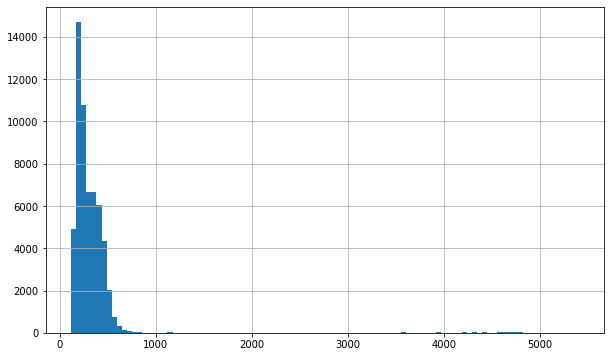

In [67]:
df['duration_sec'].hist(bins=100);

In [68]:
# Удаляем излишне длинные треки, которые по факту являются миксами
df = df[df['duration_sec']<1000]

In [69]:
# Рейтинг диджея
# Рассчитывается как величина, прямо пропорциональная средней позиции в dj mag top 100 и количеству попаданий в него
# Рейтинг диджея обратно пропорционален стандартному отклонению позиций диджея в dj mag top 100
df['dj_score'] = ((100-df['mean_position'])*df['times_in_rating'])/(df['position_std']+np.asarray(df['position_std']).mean())

In [70]:
# Год и месяц выпуска альбома
df['release_year'] = pd.to_datetime(df['album_release_date']).dt.year
df['release_month'] = pd.to_datetime(df['album_release_date']).dt.month

In [71]:
# Длина трека и имени исполнителя
df['track_name_length'] = df['track_name'].apply(lambda x: len(x))
df['main_artist_name_length'] = df['artist_name'].apply(lambda x: len(x))
df['album_name_length'] = df['album_name'].apply(lambda x: len(x))

In [72]:
# Кол-во доступных стран
df['available_markets_count'] = df['available_markets'].apply(lambda x: len(x))

In [73]:
# Количество исполнителей, задействованных в создании трека
df['artists_count'] = df['artists_names'].apply(lambda x: len(x))

In [74]:
# Идентификаторы обложек альбомов
df['cover_id'] = df['image_url'].apply(lambda x: x.partition('https://i.scdn.co/image/')[2])

In [75]:
# Попадал ли исполнитель в топ 10
df['top10_entry'] = df['positions_and_years_data'].apply(lambda x: 1 if min(x.values())<=10 else 0)

In [76]:
# Преобразуем логический признак в бинарный
df['explicit'] = (df['explicit']*1).astype(int)

In [77]:
# Удалим неправильные годы выпуска
df['release_year'].replace(1900, 2005, inplace=True)

In [78]:
df = df.drop(df[df['release_year']==1959].index)

In [79]:
df['remix'] = df['track_name'].apply(lambda x: 1 if 'remix' in x.lower() else 0)

In [80]:
# Кол-во треков и альбомов исполнителя на Spotify (подходящих по условиям)
tracks_count = df.groupby('artist_name').size().rename('tracks_count')
albums_count = df.groupby(['artist_name'])['album_name'].nunique().rename('albums_count')

In [81]:
df = df.merge(tracks_count, on='artist_name')
df = df.merge(albums_count, on='artist_name')

In [82]:
df.head(3)

,track_name,track_id,track_popularity,track_number,explicit,available_markets,artists_names,artists_ids,album_id,main_artist_id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_sec,time_signature,album_name,album_release_date,total_tracks,type,image_url,album_popularity,album_label,followers,genres,artist_name,artist_popularity,mean_position,best_position,position_std,times_in_rating,lowest position,born_or_founded_in,positions_and_years_data,dj_score,release_year,release_month,track_name_length,main_artist_name_length,album_name_length,available_markets_count,artists_count,cover_id,top10_entry,remix,tracks_count,albums_count
0,God Is A Dancer,6mIrY9axk9DkBCk4eHXL6c,41.0,1.0,0,"[AD, AE, AG, AL, AR, AT, AU, BA, BB, BE, BG, B...","[Tiësto, Mabel]","[2o5jDhtHVPhrJdv3cEQ99Z, 1MIVXf74SZHmTIp4V4paH4]",6CIslPQSknp875cigkhKJC,2o5jDhtHVPhrJdv3cEQ99Z,0.773,0.747,1.0,-3.908,0.0,0.0820,0.02410,0.000006,0.342,0.833,119.962,168.125,4.0,The London Sessions,2020-05-15,13.0,album,https://i.scdn.co/image/ab67616d00001e029759d6...,66.0,"Universal Music, a division of Universal Inter...",6229039.0,"[big room, brostep, dance pop, dutch edm, edm,...",TIËSTO,87.0,4.944444,1.0,4.235317,18.0,16.0,"Breda, Breda, Noord-Brabant, Netherlands","{2004: 1, 2005: 2, 2006: 3, 2007: 2, 2008: 2, ...",94.608063,2020,5,15,6,19,106,2,ab67616d00001e029759d6dfa2c19091814fccb3,1,0,592,40
1,Nothing Really Matters,39TATbzOKDwiWdrmuQBLGK,40.0,2.0,0,"[AD, AE, AG, AL, AR, AT, AU, BA, BB, BE, BG, B...","[Tiësto, Becky Hill]","[2o5jDhtHVPhrJdv3cEQ99Z, 4EPJlUEBy49EX1wuFOvtjK]",6CIslPQSknp875cigkhKJC,2o5jDhtHVPhrJdv3cEQ99Z,0.732,0.847,5.0,-4.255,0.0,0.0426,0.00491,0.000002,0.281,0.697,123.023,157.478,4.0,The London Sessions,2020-05-15,13.0,album,https://i.scdn.co/image/ab67616d00001e029759d6...,66.0,"Universal Music, a division of Universal Inter...",6229039.0,"[big room, brostep, dance pop, dutch edm, edm,...",TIËSTO,87.0,4.944444,1.0,4.235317,18.0,16.0,"Breda, Breda, Noord-Brabant, Netherlands","{2004: 1, 2005: 2, 2006: 3, 2007: 2, 2008: 2, ...",94.608063,2020,5,22,6,19,106,2,ab67616d00001e029759d6dfa2c19091814fccb3,1,0,592,40
2,Ride,6GpoUPegO1TBbZCoE7FxZ7,38.0,3.0,1,"[AD, AE, AG, AL, AR, AT, AU, BA, BB, BE, BG, B...","[Tiësto, The Kid Daytona, ROE]","[2o5jDhtHVPhrJdv3cEQ99Z, 1U77TS18o4qUO3bwq0pbc...",6CIslPQSknp875cigkhKJC,2o5jDhtHVPhrJdv3cEQ99Z,0.734,0.855,11.0,-4.438,1.0,0.0412,0.03970,0.000278,0.105,0.223,117.009,203.479,4.0,The London Sessions,2020-05-15,13.0,album,https://i.scdn.co/image/ab67616d00001e029759d6...,66.0,"Universal Music, a division of Universal Inter...",6229039.0,"[big room, brostep, dance pop, dutch edm, edm,...",TIËSTO,87.0,4.944444,1.0,4.235317,18.0,16.0,"Breda, Breda, Noord-Brabant, Netherlands","{2004: 1, 2005: 2, 2006: 3, 2007: 2, 2008: 2, ...",94.608063,2020,5,4,6,19,106,3,ab67616d00001e029759d6dfa2c19091814fccb3,1,0,592,40


In [83]:
# df.to_csv(path+'\Electro_music_on_Spotify.csv', index=False)

In [84]:
df.to_pickle(path+'\Electro_music_on_Spotify.pkl')

In [85]:
df = pd.read_pickle(path+'\Electro_music_on_Spotify.pkl')

In [86]:
# df = pd.read_csv(path+'\Electro_music_on_Spotify.csv')

In [87]:
df.shape

(57457, 54)

In [88]:
df.head(3)

,track_name,track_id,track_popularity,track_number,explicit,available_markets,artists_names,artists_ids,album_id,main_artist_id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_sec,time_signature,album_name,album_release_date,total_tracks,type,image_url,album_popularity,album_label,followers,genres,artist_name,artist_popularity,mean_position,best_position,position_std,times_in_rating,lowest position,born_or_founded_in,positions_and_years_data,dj_score,release_year,release_month,track_name_length,main_artist_name_length,album_name_length,available_markets_count,artists_count,cover_id,top10_entry,remix,tracks_count,albums_count
0,God Is A Dancer,6mIrY9axk9DkBCk4eHXL6c,41.0,1.0,0,"[AD, AE, AG, AL, AR, AT, AU, BA, BB, BE, BG, B...","[Tiësto, Mabel]","[2o5jDhtHVPhrJdv3cEQ99Z, 1MIVXf74SZHmTIp4V4paH4]",6CIslPQSknp875cigkhKJC,2o5jDhtHVPhrJdv3cEQ99Z,0.773,0.747,1.0,-3.908,0.0,0.0820,0.02410,0.000006,0.342,0.833,119.962,168.125,4.0,The London Sessions,2020-05-15,13.0,album,https://i.scdn.co/image/ab67616d00001e029759d6...,66.0,"Universal Music, a division of Universal Inter...",6229039.0,"[big room, brostep, dance pop, dutch edm, edm,...",TIËSTO,87.0,4.944444,1.0,4.235317,18.0,16.0,"Breda, Breda, Noord-Brabant, Netherlands","{2004: 1, 2005: 2, 2006: 3, 2007: 2, 2008: 2, ...",94.608063,2020,5,15,6,19,106,2,ab67616d00001e029759d6dfa2c19091814fccb3,1,0,592,40
1,Nothing Really Matters,39TATbzOKDwiWdrmuQBLGK,40.0,2.0,0,"[AD, AE, AG, AL, AR, AT, AU, BA, BB, BE, BG, B...","[Tiësto, Becky Hill]","[2o5jDhtHVPhrJdv3cEQ99Z, 4EPJlUEBy49EX1wuFOvtjK]",6CIslPQSknp875cigkhKJC,2o5jDhtHVPhrJdv3cEQ99Z,0.732,0.847,5.0,-4.255,0.0,0.0426,0.00491,0.000002,0.281,0.697,123.023,157.478,4.0,The London Sessions,2020-05-15,13.0,album,https://i.scdn.co/image/ab67616d00001e029759d6...,66.0,"Universal Music, a division of Universal Inter...",6229039.0,"[big room, brostep, dance pop, dutch edm, edm,...",TIËSTO,87.0,4.944444,1.0,4.235317,18.0,16.0,"Breda, Breda, Noord-Brabant, Netherlands","{2004: 1, 2005: 2, 2006: 3, 2007: 2, 2008: 2, ...",94.608063,2020,5,22,6,19,106,2,ab67616d00001e029759d6dfa2c19091814fccb3,1,0,592,40
2,Ride,6GpoUPegO1TBbZCoE7FxZ7,38.0,3.0,1,"[AD, AE, AG, AL, AR, AT, AU, BA, BB, BE, BG, B...","[Tiësto, The Kid Daytona, ROE]","[2o5jDhtHVPhrJdv3cEQ99Z, 1U77TS18o4qUO3bwq0pbc...",6CIslPQSknp875cigkhKJC,2o5jDhtHVPhrJdv3cEQ99Z,0.734,0.855,11.0,-4.438,1.0,0.0412,0.03970,0.000278,0.105,0.223,117.009,203.479,4.0,The London Sessions,2020-05-15,13.0,album,https://i.scdn.co/image/ab67616d00001e029759d6...,66.0,"Universal Music, a division of Universal Inter...",6229039.0,"[big room, brostep, dance pop, dutch edm, edm,...",TIËSTO,87.0,4.944444,1.0,4.235317,18.0,16.0,"Breda, Breda, Noord-Brabant, Netherlands","{2004: 1, 2005: 2, 2006: 3, 2007: 2, 2008: 2, ...",94.608063,2020,5,4,6,19,106,3,ab67616d00001e029759d6dfa2c19091814fccb3,1,0,592,40


### Обработка обложек альбомов

Этот этап не является обязательным, однако в теории можно было бы попробовать научить машину выделять полезные признаки из изображений обложек для предсказания популярности трека

In [89]:
image_urls = list(df.drop_duplicates(subset='album_id')['image_url'])

In [90]:
len(image_urls)

16162

In [91]:
def albums_covers_downloader(url):
    image_path = f'D:\\Albums_covers\\{url.partition("image/")[2]}.jpg'
    img_data = requests.get(url).content
    with open(image_path, 'wb') as handler:
        handler.write(img_data)

In [92]:
# %%time
# with concurrent.futures.ThreadPoolExecutor() as executor:
#     executor.map(albums_covers_downloader, image_urls)

In [93]:
def absoluteFilePaths(directory):
    for dirpath,_,filenames in os.walk(directory):
        for f in filenames:
            yield os.path.abspath(os.path.join(dirpath, f))

albums_covers = list(absoluteFilePaths('D:\\Albums_covers'))

In [94]:
# Чтение изображения (из-за кириллицы пришлось написать следующее)
cols = ['color_'+ str(i) + '_' + str(j) for i in range(1, 6) for j in ['r', 'g', 'b']]

def get_colors(image_path):
#     image = cv2.imdecode(np.fromfile(image_path, dtype=np.uint8), cv2.IMREAD_UNCHANGED)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    modified_image = image.reshape(image.shape[0] * image.shape[1], 3)
    
    clf = KMeans(n_clusters=5)
    labels = clf.fit_predict(modified_image)
    center_colors = np.round(clf.cluster_centers_, 1)
    id_ = image_path.partition('D:\\Albums_covers\\')[2].partition('.jpg')[0]    

    d1 = dict(zip(cols, center_colors.ravel()))
    d2 = {'cover_id' : id_}
    d = dict(d2, **d1)
    return d
#     file = path + '\Main_colors.json'
#     with open(file, 'a') as f:
#         f.write(json.dumps(d)+'\n')

In [95]:
# Проверить, всегда ли в artists_names содержатся имена топовых диджеев

In [96]:
def names_check(x):
    if x['artist_name'] in ([i.upper() for i in x['artists_names']]):
        return 1
    else:
        return 0

In [97]:
artist_name_check = df.apply(names_check, axis=1)

In [98]:
artist_name_check.value_counts()

1    57457
dtype: int64

Все треки собраны нормально, имена известных диджеев есть в каждом списке имен артистов для каждого трека.

# Исследовательский анализ данных

## Распределение целевой переменной - популярности треков

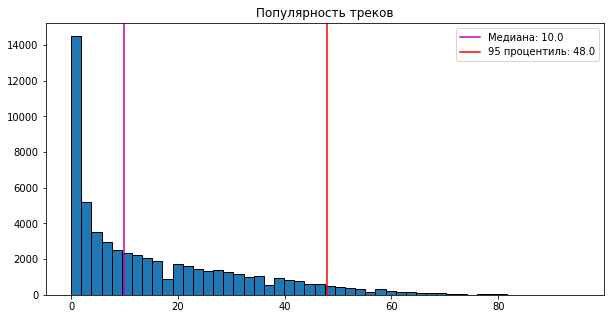

In [99]:
plt.figure(figsize=(10,5))
median_track_popularity = df['track_popularity'].median()
plt.hist(df['track_popularity'], bins=50, ec='k')
plt.axvline(median_track_popularity, color='m', label=f'Медиана: {median_track_popularity}')
plt.axvline(np.percentile(df["track_popularity"], 95), color='r', label=f'95 процентиль: {np.percentile(df["track_popularity"], 95)}')
plt.title('Популярность треков')
plt.legend();

Наблюдается сильнейший перекос на графике распределения популярности треков. Удивительно, насколько мало действительно популярных композиций! Медианой является число 10. Лишь 5% треков имеют популярность выше 48.

## Распределения признаков

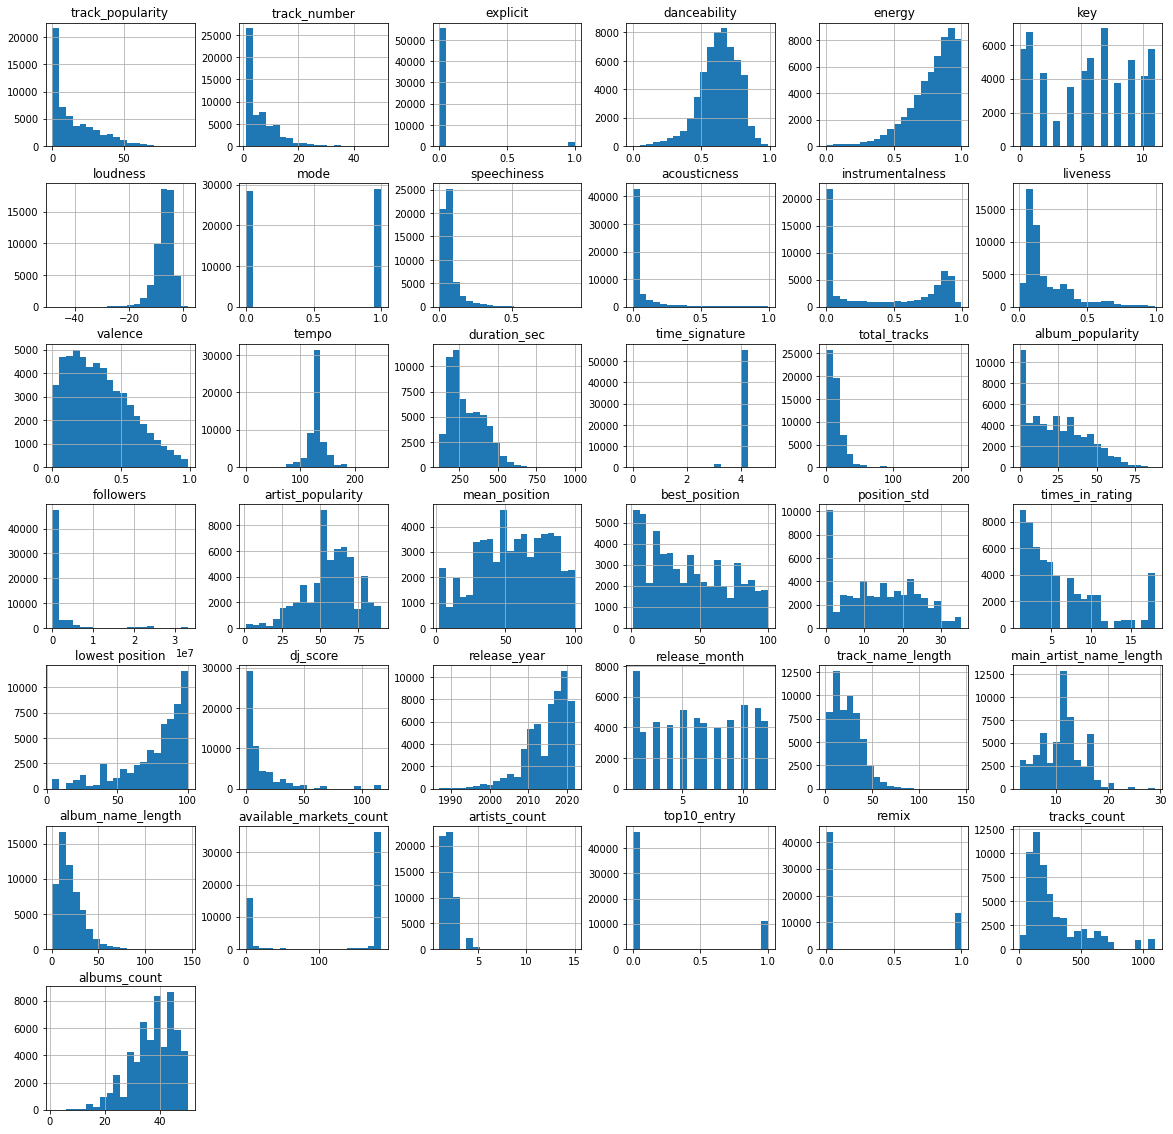

In [100]:
df.hist(bins=20, figsize=(20, 20));

Признак time_signature, который означает ритм трека (в электронной музыке почти всегда прямая бочка), можно удалить, т.к. он не несет полезной информации.

In [101]:
groups_df = df.groupby('top10_entry').describe().stack(1)
groups_df

track_popularity  track_number      explicit  danceability  \
top10_entry                                                                     
0           count      46482.000000  46482.000000  46482.000000  46482.000000   
            mean          14.925283      5.936492      0.035455      0.639515   
            std           16.198077      6.424166      0.184928      0.139638   
            min            0.000000      1.000000      0.000000      0.000000   
            25%            1.000000      1.000000      0.000000      0.552000   
            50%            9.000000      3.000000      0.000000      0.651000   
            75%           24.000000      9.000000      0.000000      0.744000   
            max           95.000000     50.000000      1.000000      0.989000   
1           count      10975.000000  10975.000000  10975.000000  10975.000000   
            mean          16.593986      8.592711      0.032711      0.594639   
            std           16.980260      7.298121      0.177886      0.140870   
            min            0.000000      1.000000      0.000000      0.052300   
            25%            2.000000      3.000000      0.000000      0.525000   
            50%           11.000000      7.000000      0.000000      0.608000   
            75%           27.000000     12.000000      0.000000      0.684000   
            max           92.000000     50.000000      1.000000      0.989000   

                         energy           key      loudness          mode  \
top10_entry                                                                 
0           count  46482.000000  46482.000000  46482.000000  46482.000000   
            mean       0.788073      5.565531     -6.991510      0.508369   
            std        0.170242      3.613966      3.227622      0.499935   
            min        0.000020      0.000000    -48.137000      0.000000   
            25%        0.699000      2.000000     -8.608750      0.000000   
            50%        0.829000      6.000000     -6.543500      1.000000   
            75%        0.920000      9.000000     -4.790000      1.000000   
            max        1.000000     11.000000      1.585000      1.000000   
1           count  10975.000000  10975.000000  10975.000000  10975.000000   
            mean       0.765657      5.421412     -7.014407      0.480729   
            std        0.184614      3.548204      3.445023      0.499651   
            min        0.000020      0.000000    -39.142000      0.000000   
            25%        0.682000      2.000000     -8.438000      0.000000   
            50%        0.813000      6.000000     -6.435000      0.000000   
            75%        0.900000      8.000000     -4.765000      1.000000   
            max        1.000000     11.000000      1.258000      1.000000   

                    speechiness  acousticness  instrumentalness      liveness  \
top10_entry                                                                     
0           count  46482.000000  46482.000000      46482.000000  46482.000000   
            mean       0.080001      0.068391          0.419815      0.201567   
            std        0.072279      0.156506          0.384534      0.177692   
            min        0.000000      0.000001          0.000000      0.007440   
            25%        0.042300      0.001210          0.002940      0.088100   
            50%        0.055300      0.008110          0.380000      0.121000   
            75%        0.084300      0.049600          0.838000      0.276000   
            max        0.934000      0.995000          0.995000      0.990000   
1           count  10975.000000  10975.000000      10975.000000  10975.000000   
            mean       0.067143      0.098693          0.358347      0.205273   
            std        0.055704      0.207469          0.386207      0.172902   
            min        0.024600      0.000001          0.000000      0.015000   
            25%        0.038600      0.

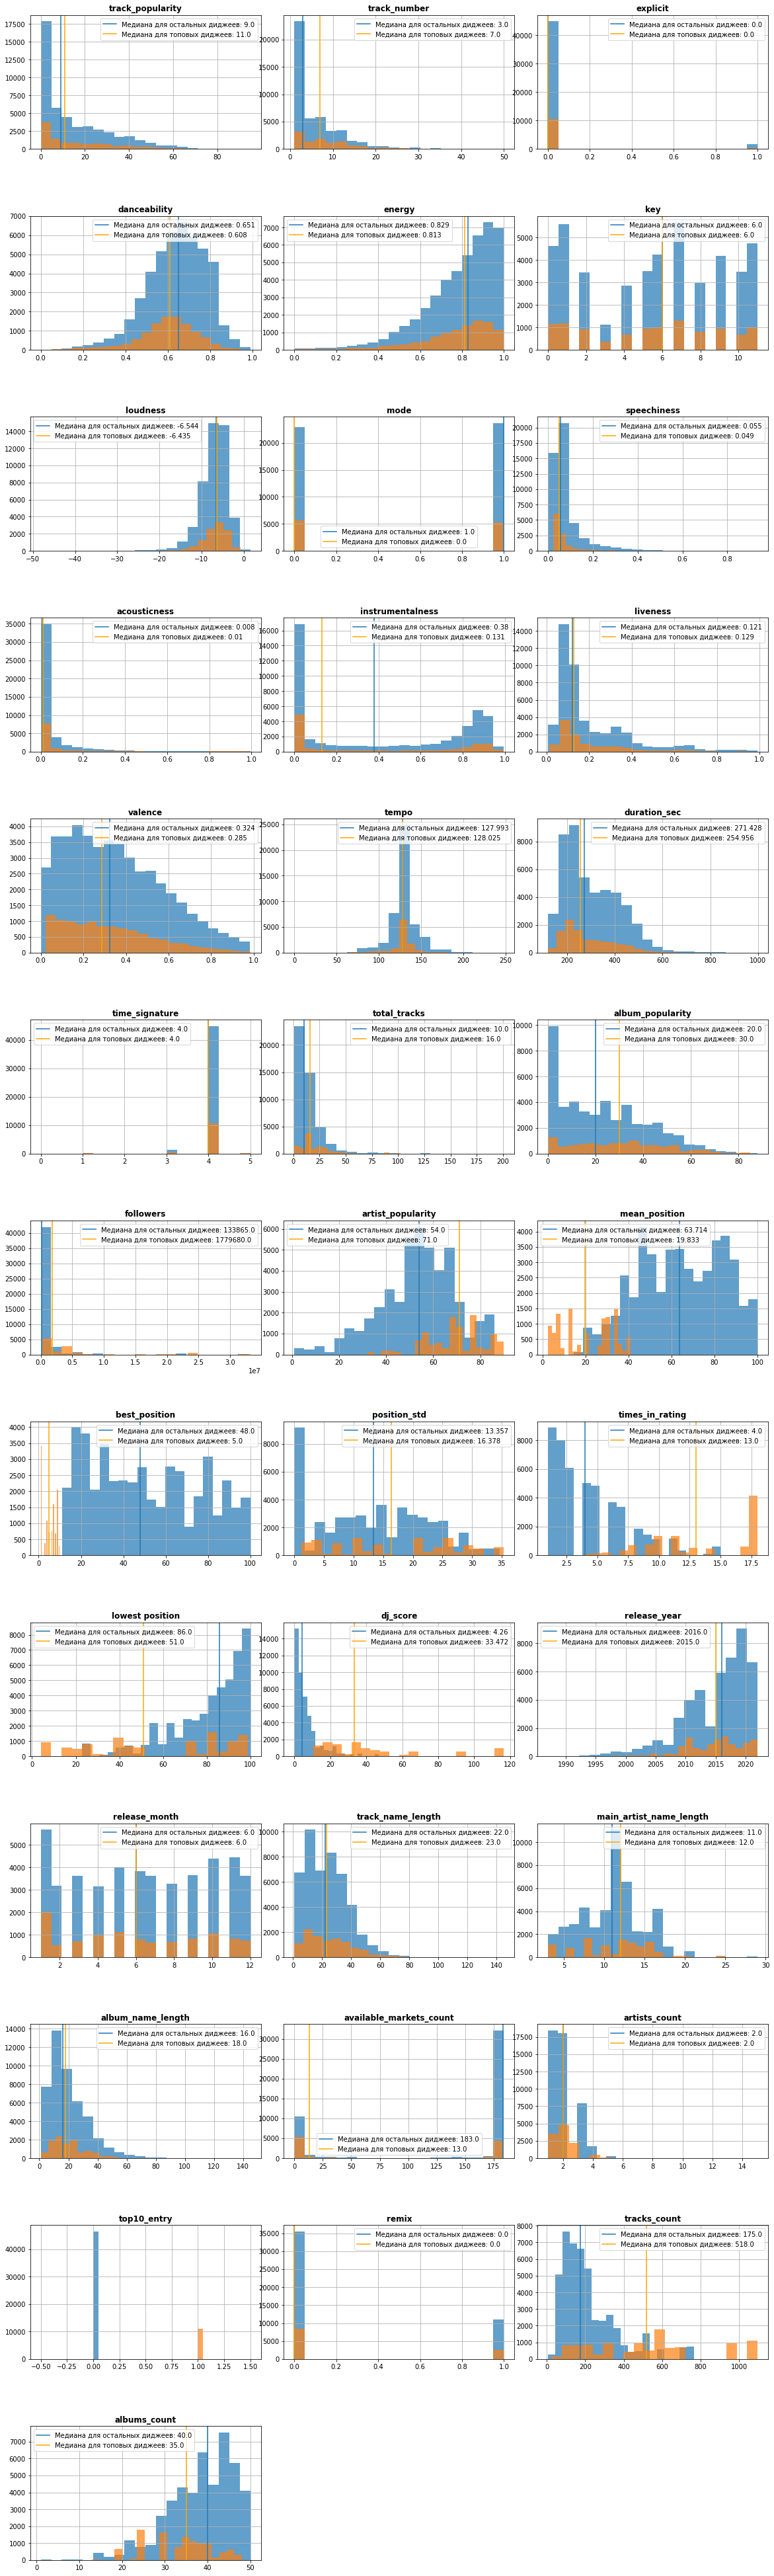

In [102]:
plt.figure(figsize=(20, 300))
plt.subplots_adjust(wspace=0.1, hspace=0.5)
for n,i in enumerate(df.select_dtypes('number'), start=1):
    if i != 'top10_entry':
        plt.subplot(df.shape[1], 3, n)
        data = df.groupby('top10_entry')[i]
        data.hist(alpha=0.7, bins=20)
        other_median = round(groups_df[i][0]['50%'], 3)
        top10_median = round(groups_df[i][1]['50%'], 3)
        plt.axvline(other_median, label=f'Медиана для остальных диджеев: {other_median}')
        plt.axvline(top10_median, color='orange', label=f'Медиана для топовых диджеев: {top10_median}')
        plt.title(i, weight='heavy')
        plt.legend()
    else:
        plt.subplot(df.shape[1], 3, n)
        data = df.groupby('top10_entry')[i]
        data.hist(alpha=0.7, bins=20)
        plt.title(i, weight='heavy')
plt.show()

**У топовых испольнителей**: <br>
признак danceability (танцевальность) чуть ниже, чем у остальных <br>
длительность треков чуть меньше <br>
Количество треков в альбомах, как правило, больше  <br>
Популярность альбомов реже бывает околонулевой, в отличие от остальных исполнителей <br>
Больше подписчиков, что логично <br>
Треки реже доступны во многих странах мира, что довольно странно <br>

## Лучшие диджеи

In [103]:
djs_rating_df = df[['artist_name', 'dj_score']].drop_duplicates(subset='artist_name')\
    .sort_values(by='dj_score', ascending=False)\
    .reset_index(drop=True)

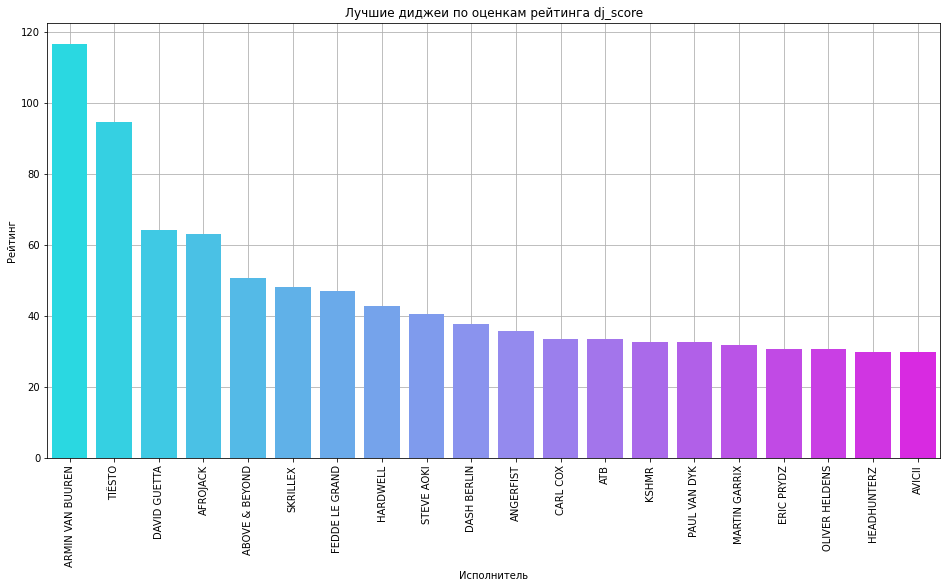

In [104]:
plt.figure(figsize=(16, 8))
sns.barplot(data=djs_rating_df[:20], x='artist_name', y='dj_score', palette='cool', zorder=2)
plt.grid(True)
plt.xlabel('Исполнитель')
plt.ylabel('Рейтинг')
plt.title('Лучшие диджеи по оценкам рейтинга dj_score')
plt.xticks(rotation=90);

Armin van Buuren является лидером в данном рейтинге. Он часто и стабильно занимает высокие места в DJ Mag Top 100

## Корреляции

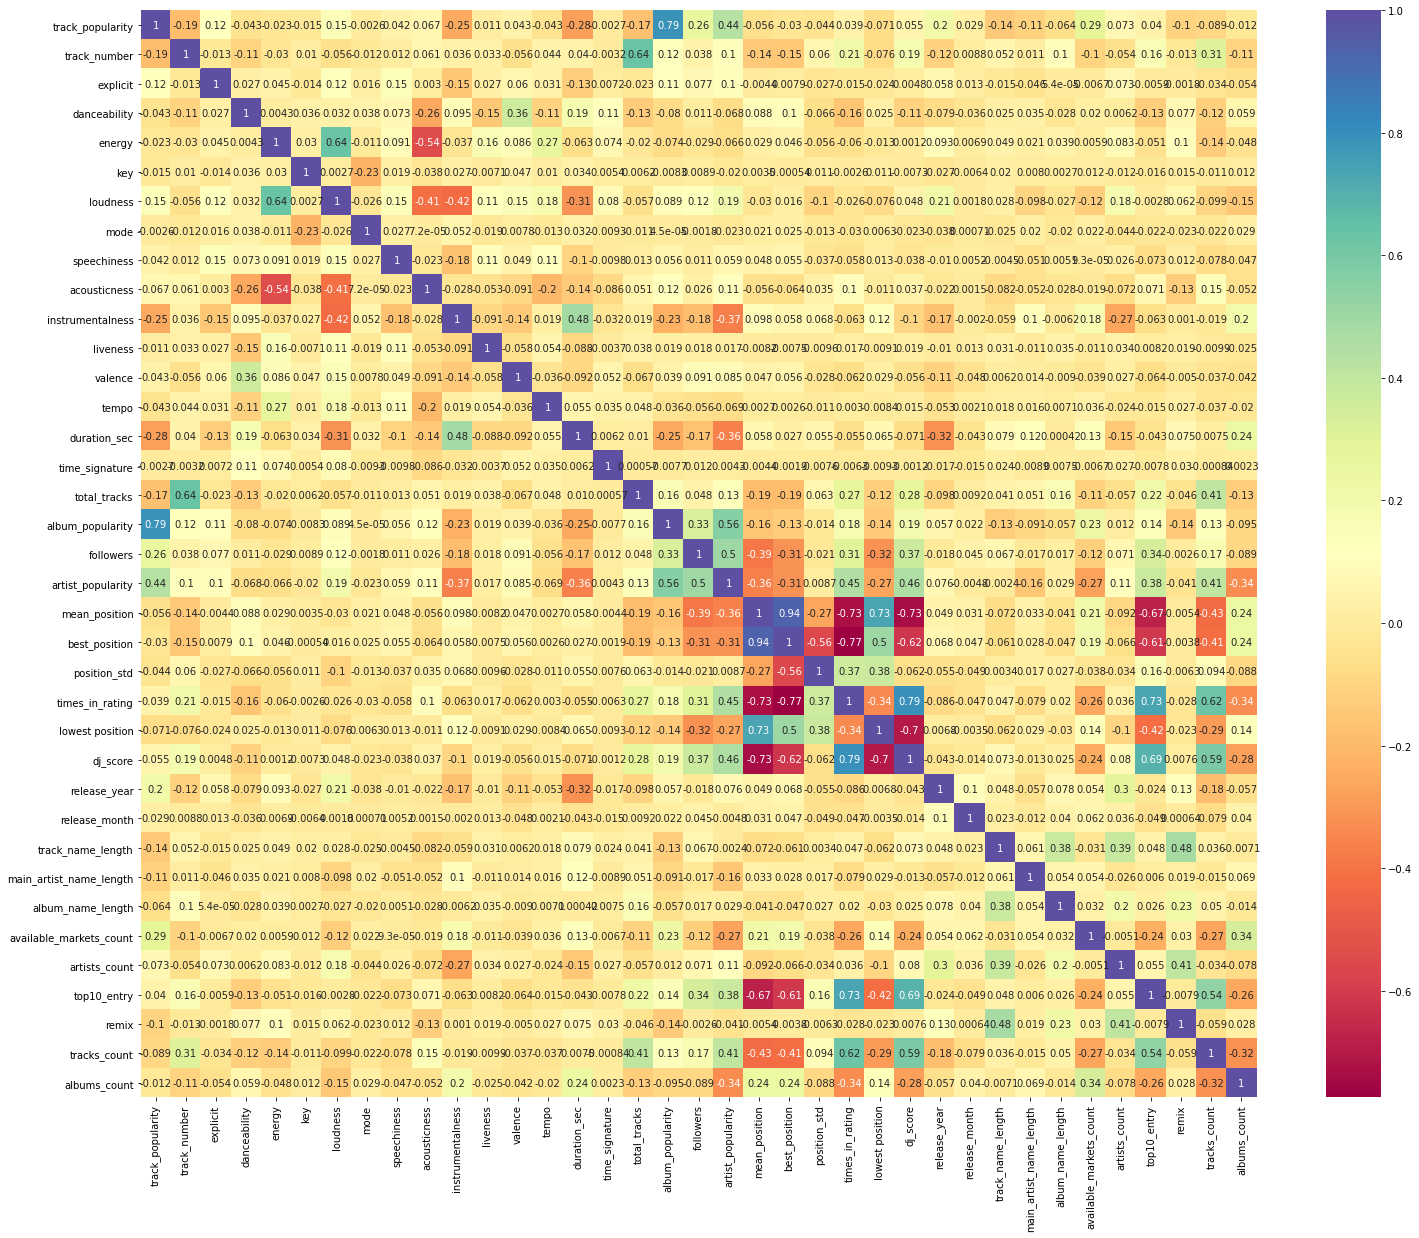

In [105]:
plt.figure(figsize=(25,20))
sns.heatmap(df.corr(), annot=True, cmap='Spectral');

По карте корреляций можно сделать некоторые **выводы**: <br>
1)Популярность трека имеет явную корреляцию с популярностью самого исполнителя. Многие музыкальные характеристики здесь не играют решающей роли. <br>
2)Инструментальная музыка менее популярна. Впрочем, странно употреблять понятие "инструментальность" в электронной музыке. <br>
3)Есть отрицательная корреляция между популярностью трека и его продолжительностью. Иными словами, популярные треки не должны быть слишком длинными.<br>
4)Существует сильная корреляция между популярностью альбома и популярностью трека. Однако остается неясным: популярность трека является следствием популярности альбома в целом или же отдельный трек сделал альбом более популярным?

In [106]:
# Нужно выяснить, что первично: популярность трека или альбома

In [107]:
popularity_df = df.groupby('album_id').agg({'track_popularity':['count', 'mean', 'median', 'max'], 'album_popularity':['mean']})
popularity_df['popularity_diff'] = popularity_df['album_popularity']['mean'] - popularity_df['track_popularity']['mean']
popularity_df = popularity_df[popularity_df['track_popularity']['count']>1]

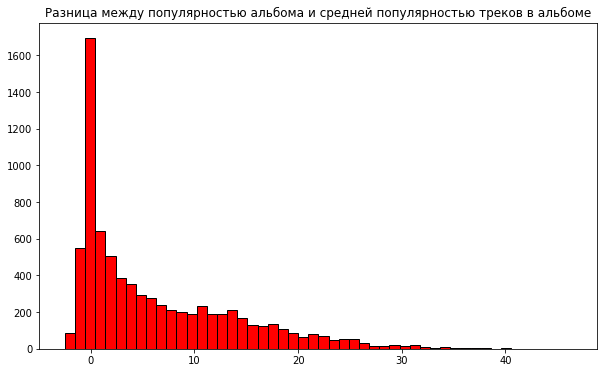

In [108]:
popularity_df['popularity_diff'].hist(
    bins=50,
    color='r',
    ec='k',
    grid=False
)
plt.title('Разница между популярностью альбома и средней популярностью треков в альбоме');

Стоит оговориться, что альбомами мы будем считать те альбомы, в которых число треков более 1. Тогда на графике видно, что зачастую популярность альбома выше, чем средняя популярность треков. В немалой доли случаев разницы нет. Объективно ответить на поставленный вопрос вряд ли получится, т.к. принцип оценивания популярности на Spotify остается загадкой.

## Попадания в рейтинг

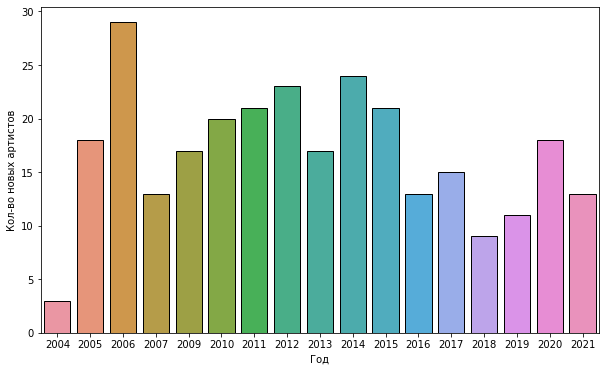

In [109]:
data = djs_df[djs_df['position_movement']=='New Entry'].groupby(['year'], as_index=False).size()
sns.barplot(data=data, x='year', y='size', ec='k')
plt.ylabel('Кол-во новых артистов')
plt.xlabel('Год');

Больше всего новых диджеев попало в рейтинг в 2006 году. В последние годы в рейтинг попадает достаточно небольшое количество новых звезд.

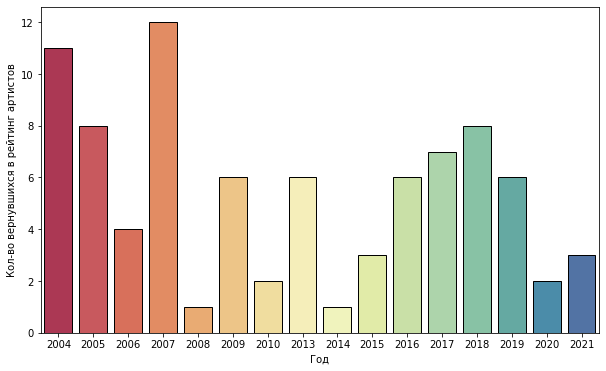

In [110]:
data = djs_df[djs_df['position_movement']=='Re-entry'].groupby(['year'], as_index=False).size()
sns.barplot(data=data, x='year', y='size', ec='k', palette='Spectral')
plt.ylabel('Кол-во вернувшихся в рейтинг артистов')
plt.xlabel('Год');

Больше всего диджеев повторно вошли в рейтинг в 2007 году. Обычно туда возвращаются немногие.

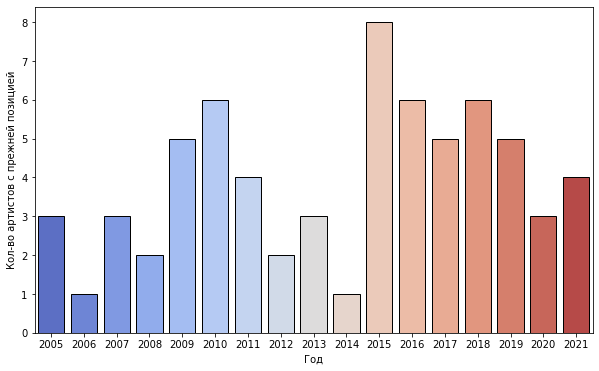

In [111]:
data = djs_df[djs_df['position_movement']=='Non Mover'].groupby(['year'], as_index=False).size()
sns.barplot(data=data, x='year', y='size', ec='k', palette='coolwarm')
plt.ylabel('Кол-во артистов c прежней позицией')
plt.xlabel('Год');

In [112]:
data = djs_df[djs_df['position_movement']=='Non Mover'].groupby(['name'], as_index=False).size()

In [113]:
pd.merge(data.sort_values(by='size', ascending=False)[:10],
         djs_rating_df,
         left_on='name',
         right_on='artist_name').drop('artist_name', axis=1)

,name,size,dj_score
0,ARMIN VAN BUUREN,7,116.552977
1,TIËSTO,6,94.608063
2,SKRILLEX,3,48.007321
3,ABOVE & BEYOND,2,50.646464
4,MARTIN GARRIX,2,31.788910
5,FEDDE LE GRAND,2,47.114219
6,DIMITRI VEGAS & LIKE MIKE,2,25.054482
7,DAVID GUETTA,2,64.105365
8,W&W,2,27.154178
9,AFROJACK,2,62.999765


Наиболее часто стабильно держатся именно наиболее популярные диджеи (см.топ 20 на 8.3)

## Самые популярные треки

In [114]:
top_10_tracks = df.sort_values(by='track_popularity', ascending=False)[:10]
top_10_tracks

,track_name,track_id,track_popularity,track_number,explicit,available_markets,artists_names,artists_ids,album_id,main_artist_id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_sec,time_signature,album_name,album_release_date,total_tracks,type,image_url,album_popularity,album_label,followers,genres,artist_name,artist_popularity,mean_position,best_position,position_std,times_in_rating,lowest position,born_or_founded_in,positions_and_years_data,dj_score,release_year,release_month,track_name_length,main_artist_name_length,album_name_length,available_markets_count,artists_count,cover_id,top10_entry,remix,tracks_count,albums_count
53227,Where Are You Now,3uUuGVFu1V7jTQL60S1r8z,95.0,1.0,0,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...","[Lost Frequencies, Calum Scott]","[7f5Zgnp2spUuuzKplmRkt7, 6ydoSd3N2mwgwBHtF6K7eX]",5YrOK7zze6egKg9a8WRcnD,7f5Zgnp2spUuuzKplmRkt7,0.671,0.636,6.0,-8.117,0.0,0.1030,0.51500,0.000411,0.1720,0.262,120.966,148.197,4.0,Where Are You Now,2021-07-30,1.0,album,https://i.scdn.co/image/ab67616d00001e028d7a7f...,88.0,Epic Amsterdam,2355911.0,"[belgian edm, edm, pop, pop dance, tropical ho...",LOST FREQUENCIES,82.0,21.800000,17.0,3.701351,5.0,26.0,"Brussels, Belgium","{2017: 26, 2018: 17, 2019: 20, 2020: 21, 2021:...",22.277713,2021,7,17,16,17,184,2,ab67616d00001e028d7a7f1855b04104ba59c18b,0,0,527,25
25929,Moth To A Flame (with The Weeknd),2gpWyfu7eZ01zzncHpxOtA,92.0,1.0,0,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...","[Swedish House Mafia, The Weeknd]","[1h6Cn3P4NGzXbaXidqURXs, 1Xyo4u8uXC1ZmMpatF05PJ]",3udIvIqyBG1RrHxXrUZDoK,1h6Cn3P4NGzXbaXidqURXs,0.542,0.659,8.0,-7.289,1.0,0.0389,0.00279,0.000000,0.1050,0.109,120.122,234.000,4.0,Moth To A Flame,2021-10-22,1.0,album,https://i.scdn.co/image/ab67616d00001e022751f1...,85.0,Republic Records,3499362.0,"[dance pop, edm, electro house, pop, pop dance...",SWEDISH HOUSE MAFIA,80.0,37.142857,10.0,27.631073,7.0,84.0,"Stockholm, Stockholm municipality, Stockholms ...","{2010: 23, 2011: 10, 2012: 12, 2013: 26, 2018:...",10.607293,2021,10,33,19,15,184,2,ab67616d00001e022751f15ff6c8174e540b6fb4,1,0,130,39
47536,Thunder,2USlegnFJLrVLpoVfPimKB,89.0,1.0,0,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...","[Gabry Ponte, LUM!X, Prezioso]","[5ENS85nZShljwNgg4wFD7D, 0TKFPt9w0AAEnhB9bd0pL...",35Q09Y0b7ZxOoCdF7sBiGf,5ENS85nZShljwNgg4wFD7D,0.670,0.896,1.0,-4.673,1.0,0.0580,0.03420,0.000032,0.3440,0.403,101.216,160.000,3.0,Thunder,2021-05-07,1.0,album,https://i.scdn.co/image/ab67616d00001e02fd1358...,82.0,Spinnin' Records,338676.0,"[eurodance, europop, italo dance, slap house]",GABRY PONTE,79.0,61.000000,61.0,0.000000,1.0,61.0,"Turin, Torino, Piemonte, Italy",{2014: 61},2.815921,2021,5,7,11,7,182,3,ab67616d00001e02fd13588a958fbd23d5524e1b,0,0,127,26
36375,The Nights,0ct6r3EGTcMLPtrXHDvVjc,89.0,2.0,0,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",[Avicii],[1vCWHaC5f2uS3yhpwWbIA6],0h2knr6qpiAq0tV5ri5JMF,1vCWHaC5f2uS3yhpwWbIA6,0.527,0.835,6.0,-5.298,1.0,0.0433,0.01660,0.000000,0.2490,0.654,125.983,176.658,4.0,The Days / Nights,2014-01-01,4.0,album,https://i.scdn.co/image/ab67616d00001e020ae4f4...,82.0,Universal Music AB,21434150.0,"[dance pop, edm, pop, pop dance, pop rap]",AVICII,84.0,13.111111,3.0,12.464394,9.0,39.0,"Swedish EDM DJ and record producer, born 8 Sep...","{2010: 39, 2011: 6, 2012: 3, 2013: 3, 2014: 6,...",29.717777,2014,1,10,6,17,184,1,ab67616d00001e020ae4f4d42e4a09f3a29f64ad,1,0,212,43
36417,Wake Me Up,0nrRP2bk19rLc0orkWPQk2,88.0,1.0,0,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",[Avicii],[1vCWHaC5f2uS3yhpwWbIA6],2H6i2CrWgXE1HookLu8Au0,1vCWHaC5f2uS3yhpwWbIA6,0.532,0.783,2.0,-5.697,1.0,0.0523,0.00380,0.001200,0.1610,0.643,124.080,247.427,4.0,True,2013-01-01,10.0,album,https://i.scdn.co/image/ab67616d00001e02e14f11...,84.0,Universal Music AB,21434150.0,"[dance pop, edm, pop, pop dance, pop rap]",AVICII,84.0,13.111111,3.0,12.464394,9.0,39.0,"Swedish EDM DJ and record producer, born 8 Sep..."

In [115]:
top_10_tracks.describe()

,track_popularity,track_number,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_sec,time_signature,total_tracks,album_popularity,followers,artist_popularity,mean_position,best_position,position_std,times_in_rating,lowest position,dj_score,release_year,release_month,track_name_length,main_artist_name_length,album_name_length,available_markets_count,artists_count,top10_entry,remix,tracks_count,albums_count
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,1.000000e+01,10.000000,10.000000,10.00000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.0,10.000000,10.000000
mean,88.900000,1.100000,0.100000,0.629200,0.752800,3.900000,-5.667800,0.900000,0.053660,0.128185,0.000165,0.194380,0.498800,119.147900,188.638100,3.900000,2.200000,82.200000,1.269361e+07,82.400000,33.006768,16.30000,17.393185,6.500000,63.900000,16.270110,2019.100000,5.400000,21.400000,11.400000,17.500000,183.700000,1.900000,0.600000,0.0,201.700000,37.900000
std,2.685351,0.316228,0.316228,0.080642,0.116938,3.381321,1.232229,0.316228,0.027060,0.189631,0.000386,0.129313,0.189169,11.972845,38.546781,0.316228,2.898275,2.740641,1.136759e+07,2.716207,19.261788,19.02659,11.465634,2.953341,29.380455,10.219843,3.381321,3.777124,17.244645,4.971027,14.508618,0.674949,0.737865,0.516398,0.0,121.446879,8.517303
min,86.000000,1.000000,0.000000,0.527000,0.524000,0.000000,-8.117000,0.000000,0.031000,0.002260,0.000000,0.060800,0.109000,95.010000,148.197000,3.000000,1.000000,79.000000,3.386760e+05,79.000000,12.833333,3.00000,0.000000,1.000000,26.000000,2.235790,2013.000000,1.000000,4.000000,6.000000,4.000000,182.000000,1.000000,0.000000,0.0,109.000000,25.000000
25%,87.250000,1.000000,0.000000,0.555250,0.678750,1.000000,-6.057750,1.000000,0.035225,0.007000,0.000000,0.112750,0.422000,120.012500,160.316750,4.000000,1.000000,80.250000,3.271948e+06,80.000000,15.283333,5.25000,9.029537,5.250000,39.000000,10.654871,2017.250000,2.000000,7.750000,6.500000,6.250000,184.000000,1.250000,0.000000,0.0,128.500000,31.250000
50%,88.000000,1.000000,0.000000,0.635500,0.783500,4.000000,-5.448500,1.000000,0.041800,0.031100,0.000000,0.151500,0.570000,122.523000,175.910500,4.000000,1.000000,81.500000,1.131259e+07,83.000000,33.428571,8.00000,17.049691,7.000000,65.500000,15.233997,2021.000000,5.000000,13.500000,10.500000,16.000000,184.000000,2.000000,1.000000,0.0,182.500000,40.500000
75%,89.000000,1.000000,0.000000,0.681500,0.823000,6.750000,-4.797000,1.000000,0.056575,0.174300,0.000025,0.229750,0.641500,124.803250,221.431500,4.000000,1.000000,83.500000,2.078827e+07,84.750000,36.993506,16.00000,28.888685,8.500000,93.750000,23.616850,2021.000000,7.000000,32.500000,16.000000,22.250000,184.000000,2.000000,1.000000,0.0,210.750000,43.000000
max,95.000000,2.000000,1.000000,0.748000,0.896000,8.000000,-4.179000,1.000000,0.103000,0.515000,0.001200,0.481000,0.661000,134.981000,247.427000,4.000000,10.000000,88.000000,3.320188e+07,86.000000,67.666667,61.00000,29.535290,11.000000,98.000000,29.717777,2022.000000,12.000000,50.000000,19.000000,50.000000,184.000000,3.000000,1.000000,0.0,527.000000,48.000000


Так выглядит топ 10 наиболее популярных электронных треков на Spotify. Интересно то, что абсолютно все из исполнителей, написавших эти треки, имеют высокую популярность изначально. Или же кто-то из них стрельнул сразу? Необходимо выяснить.

In [116]:
top_tracks_artists_df = df[df['artist_name'].isin(list(top_10_tracks['artist_name'].unique()))]
top_tracks_artists_df.head(2)

,track_name,track_id,track_popularity,track_number,explicit,available_markets,artists_names,artists_ids,album_id,main_artist_id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_sec,time_signature,album_name,album_release_date,total_tracks,type,image_url,album_popularity,album_label,followers,genres,artist_name,artist_popularity,mean_position,best_position,position_std,times_in_rating,lowest position,born_or_founded_in,positions_and_years_data,dj_score,release_year,release_month,track_name_length,main_artist_name_length,album_name_length,available_markets_count,artists_count,cover_id,top10_entry,remix,tracks_count,albums_count
25891,One (Your Name),6rAjsnKhnFRQdHyBFqOMNQ,4.0,14.0,0,"[AE, AL, AR, AT, AU, BA, BE, BG, BH, BO, BR, B...","[Swedish House Mafia, Pharrell]","[1h6Cn3P4NGzXbaXidqURXs, 04lYHhZffeTajUZfUF5mCx]",3pfBrLwDEhXQIcoGTFzwPS,1h6Cn3P4NGzXbaXidqURXs,0.859,0.655,2.0,-6.161,1.0,0.0686,0.00879,0.124,0.0547,0.208,125.034,349.882,4.0,2000's Dance Hits,2022-02-25,41.0,album,https://i.scdn.co/image/ab67616d00001e0286def0...,36.0,"UMG Recordings, Inc.",3499362.0,"[dance pop, edm, electro house, pop, pop dance...",SWEDISH HOUSE MAFIA,80.0,37.142857,10.0,27.631073,7.0,84.0,"Stockholm, Stockholm municipality, Stockholms ...","{2010: 23, 2011: 10, 2012: 12, 2013: 26, 2018:...",10.607293,2022,2,15,19,17,96,2,ab67616d00001e0286def0206e04331534e09c9d,1,0,130,39
25892,Greyhound,2GbsctzYNoSBeFpjmumbQd,26.0,1.0,0,[US],[Swedish House Mafia],[1h6Cn3P4NGzXbaXidqURXs],0IaSHcgwFych3YIScdBDyW,1h6Cn3P4NGzXbaXidqURXs,0.723,0.806,0.0,-4.989,1.0,0.0521,0.00666,0.876,0.2760,0.539,124.976,410.097,4.0,Until Now,2012-01-01,10.0,album,https://i.scdn.co/image/ab67616d00001e02899774...,31.0,Virgin Records,3499362.0,"[dance pop, edm, electro house, pop, pop dance...",SWEDISH HOUSE MAFIA,80.0,37.142857,10.0,27.631073,7.0,84.0,"Stockholm, Stockholm municipality, Stockholms ...","{2010: 23, 2011: 10, 2012: 12, 2013: 26, 2018:...",10.607293,2012,1,9,19,9,1,1,ab67616d00001e028997747ca2022f8b311a770f,1,0,130,39


In [117]:
djs_work_len = top_10_tracks.groupby('artist_name')['release_year'].min(
) - top_tracks_artists_df.groupby('artist_name')['release_year'].min()
djs_work_len

artist_name
ALESSO                  6
AVICII                  0
GABRY PONTE            17
GALANTIS                6
LOST FREQUENCIES        5
MARSHMELLO              5
SWEDISH HOUSE MAFIA    11
THE CHAINSMOKERS        1
Name: release_year, dtype: int64

In [118]:
djs_work_len.mean()

6.375

Многим диджеям пришлось работать и писать треки несколько лет, прежде чем они написали действительно популярный трек. Есть и исключения. Допускаю, что на Spotify содержатся не все треки артистов, поскольку Avicii, например, и в 2012 году писал музыку. Но если даже данные где-то искажены, общая картина все равно такая, что популярность обычно не приходит сразу

## Жанры

In [162]:
df['main_genres'] = df['genres'].str[0]

In [163]:
df.main_genres.unique()

array(['big room', 'german techno', 'progressive house',
       'classic progressive house', 'dutch trance', 'uplifting trance',
       'deep uplifting trance', nan, 'house argentino',
       'bristol electronic', 'minimal techno', 'deep disco house',
       'trance', 'frankfurt electronic', 'big beat', 'hindi indie',
       'diva house', 'acid house', 'house', 'tribal house', 'uk house',
       'dutch edm', 'german dance', 'belgian techno', 'belgian dance',
       'deep house', 'dance pop', 'hard house', 'tech house',
       'disco house', 'bubble trance', 'progressive trance',
       'german trance', 'gabba', 'edm', 'japanese electronic',
       'classic hardstyle', 'chicago house', 'electronica',
       'garage house', 'canadian electronic', 'dark techno',
       'organic house', 'afrofuturism', 'classic house', 'acid techno',
       'psychedelic trance', 'full on', 'mexican edm',
       'alternative dance', 'italian techno', 'dutch tech house',
       'funky tech house', 'progressi

In [169]:
top_genres = df.groupby('main_genres').size().sort_values(ascending=False)[:20]

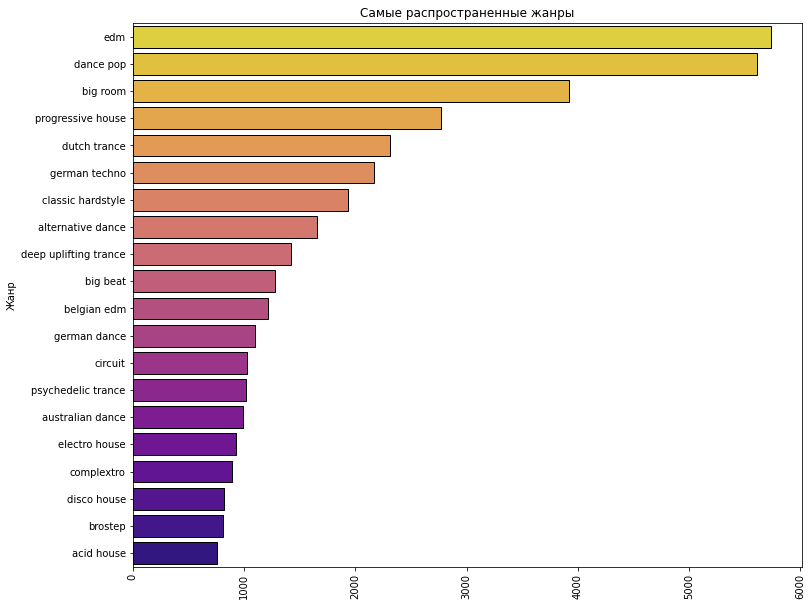

In [180]:
plt.figure(figsize=(12, 10))
sns.barplot(data=top_genres.to_frame(), y=top_genres.index, x=top_genres, ec='k', palette='plasma_r')
plt.title('Самые распространенные жанры')
plt.ylabel('Жанр')
plt.xticks(rotation=90);

Таковы наиболее популярные музыкальные жанры в электронной музыке по полученным данным. В идеале, можно было бы объединить жанры в более общие группы, но это уже совсем другая история

# Обучение моделей

## Построение моделей

In [119]:
import category_encoders as ce
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.model_selection import GridSearchCV, cross_val_score, RepeatedStratifiedKFold, RandomizedSearchCV, cross_validate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import SCORERS

In [120]:
X = df.drop(columns=[
    'track_popularity', 'time_signature', 'track_name', 'track_id',
    'available_markets', 'artists_names', 'artists_ids', 'album_id',
    'main_artist_id', 'album_name', 'album_release_date', 'type', 'image_url', 
    'genres', 'born_or_founded_in',
    'positions_and_years_data', 'cover_id', 'album_label'
]) #'artist_name', 'album_label'
y = df['track_popularity']

In [121]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [122]:
scaler = StandardScaler()
bin_encoder = ce.BinaryEncoder(['artist_name', 'album_label'])
power_tr = PowerTransformer()

In [123]:
xgb = XGBRegressor(n_jobs=-1)
lgb = LGBMRegressor(n_jobs=-1)
rf = RandomForestRegressor(n_jobs=-1)

In [124]:
def scorer(regressor):    
    model = Pipeline([
            ('cat_tr', bin_encoder),
            ('power_tr', power_tr),
            ('scaler', scaler),
            ('regressor', regressor)
        ])
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    kfold = KFold(n_splits=5)
    MAE = cross_val_score(model, X_train, y_train, cv=kfold, scoring='neg_mean_absolute_error').mean()
    MSE = cross_val_score(model, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error').mean()
    R2 = cross_val_score(model, X_train, y_train, cv=kfold, scoring='r2').mean()
    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    sns.distplot(y_test, ax=ax1, color='lime')
    ax1.set_title('Тестовая популярность')
    
    sns.distplot(y_pred, ax=ax2, color='m')
    ax2.set_title('Предсказанная популярность')
    plt.suptitle("\n".join([f'Имя регрессора: {str(regressor).partition("(")[0]}\n',
                            f'Средняя абсолютная ошибка: {-MAE}', 
                            f'Средняя квадратичная ошибка: {-MSE}',
                           f'Коэффициент детерминации: {R2}']), y=0);

## Результаты

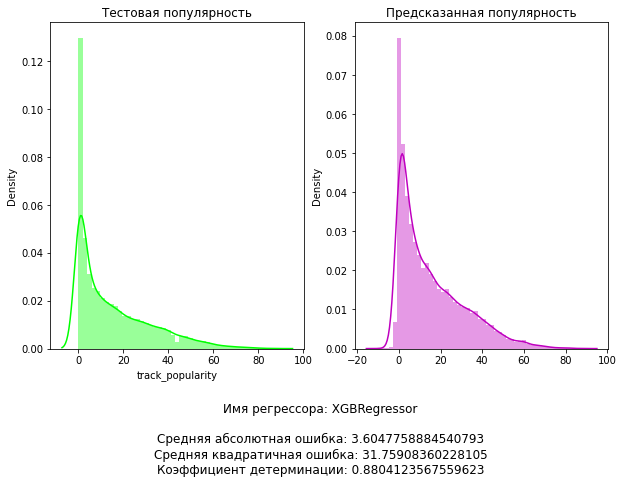

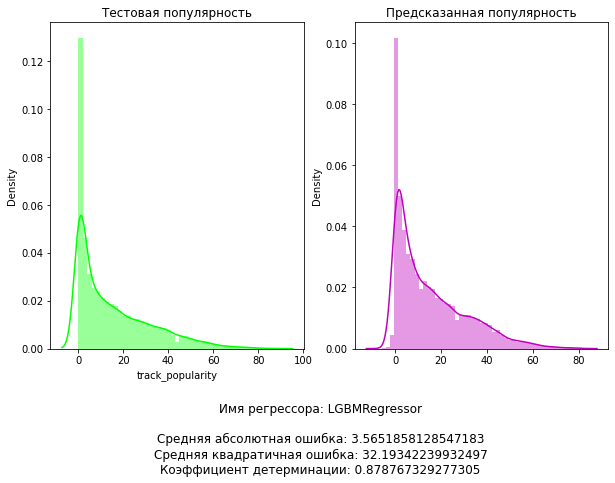

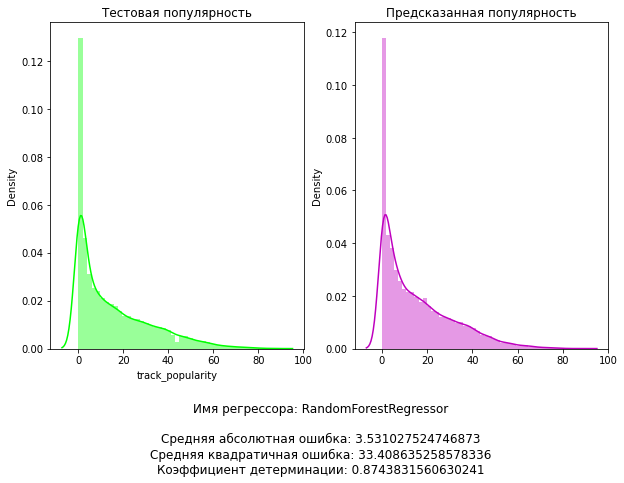

In [125]:
for r in [xgb, lgb, rf]:
    scorer(r)

XGBRegressor справился лучше всего

## Сохранение моделей

In [131]:
from joblib import dump, load

In [127]:
# dump(xgb, r'C:\Users\Максим\Desktop\Аналитика данных\Машинное обучение\Модели\xgb_spotify.joblib')
# dump(lgb, r'C:\Users\Максим\Desktop\Аналитика данных\Машинное обучение\Модели\lgb_spotify.joblib')
# dump(rf, r'C:\Users\Максим\Desktop\Аналитика данных\Машинное обучение\Модели\rf_sporify.joblib')

In [128]:
# xgb = load(r'C:\Users\Максим\Desktop\Аналитика данных\Машинное обучение\Модели\xgb_spotify.joblib')